In [81]:
import langchain
import pandas as pd
import vertexai
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_core.documents import Document
import os
import numpy as np
import tiktoken
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer
import voyageai

In [82]:
voyageai.api_key = os.getenv("VOYAGE_API")
vo = voyageai.Client()

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"..\gcpservicekey.json"
PROJECT_ID = "lawrag"
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

def chunk_text(text, max_tokens=1024, overlap=128):
    tokenizer = tiktoken.get_encoding("cl100k_base")
    tokens = tokenizer.encode(text)
    chunks = []
    start = 0
    while start < len(tokens):
        chunk = tokens[start:start + max_tokens]
        chunks.append(tokenizer.decode(chunk))
        start += max_tokens - overlap
    return chunks

def get_embeddings(texts, model="voyage-law-2", batch_size=32):
    """
    Compute embeddings using the VoyageAI Python client in batches.

    Args:
        texts (list of str): List of text data to embed.
        model (str): The embedding model to use.
        batch_size (int): Number of texts per batch.

    Returns:
        list: List of embedding vectors.
    """
    embeddings = []

    texts = [str(text) for text in texts]  

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size] 
        
        try:
            response = vo.embed(batch, model=model)
            batch_embeddings = response.embeddings  
            embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}: {e}")

    return embeddings
    
def get_embeddings(texts, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.embed_documents(batch)
        embeddings.extend(batch_embeddings)
    return embeddings

def find_most_similar(sample_list, sample1_list, embeddings_model, doc):
    results = {"sample": [], "sample1": [], "sample_most_similar_index": [], "sample1_most_similar_index": []}
    embeddings = np.vstack(doc['Embedding'].values)
    
    for sample, sample1 in zip(sample_list, sample1_list):
        # Process sample
        chunked_sample = chunk_text(sample)
        query_embedding_sample = get_embeddings(chunked_sample, embeddings_model)
        query_embedding_sample = np.array(query_embedding_sample).reshape(1, -1)
        similarities_sample = cosine_similarity(query_embedding_sample, embeddings)
        most_similar_index_sample = np.argsort(similarities_sample[0])[-5:][::-1]
        
        # Process sample1
        chunked_sample1 = chunk_text(sample1)
        query_embedding_sample1 = get_embeddings(chunked_sample1, embeddings_model)
        query_embedding_sample1 = np.array(query_embedding_sample1).reshape(1, -1)
        similarities_sample1 = cosine_similarity(query_embedding_sample1, embeddings)
        most_similar_index_sample1 = np.argsort(similarities_sample1[0])[-5:][::-1]
        
        # Store results
        results["sample"].append(sample)
        results["sample1"].append(sample1)
        results["sample_most_similar_index"].append(list(most_similar_index_sample))
        results["sample1_most_similar_index"].append(list(most_similar_index_sample1))
    
    return pd.DataFrame(results)


In [13]:
import random
import re

def get_random_sentence(paragraph):
    sentences = re.split(r'(?<=[.!?]) +', paragraph)  # Split text by sentence boundaries
    return random.choice(sentences) if sentences else ""


In [67]:
import google.generativeai as genai

# Configure API key
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Initialize model
model = genai.GenerativeModel("gemini-1.5-flash")

def paraphrase_text(text):
    response = model.generate_content(f"Paraphrase this: {text}")
    return response.text


In [ ]:
# Initialize model
embeddings_model1 = VertexAIEmbeddings(model_name="text-embedding-005")
# Load document
doc = pd.read_parquet(r"..\New_Embeddings_2025\embeddings_gemini_text-005.parquet", engine="pyarrow")

# Define sample lists
sample1= "Whoever harbors or conceals any person who he knows, or has reasonable grounds to believe or suspect, has committed, or is about to commit, an offense under this section, shall be fined under this title or imprisoned not more than ten years, or both."
sample2= "Any property, real or personal, used or intended to be used to commit or to facilitate the commission of any violation of this chapter."
sample3="participates in a strike, or asserts the right to strike, against the Government of the United States or the government of the District of Columbia; or"
sample4 = "Whoever, being an officer or other person charged by any Act of Congress with the safe-keeping of the public moneys, loans, uses, or converts to his own use, or deposits in any bank, including any branch"
sample5 = "evidence has been presented by the foreign government that indicates that had the offenses been committed in the United States, they would constitute crimes of violence as defined under section 16 of this title"
sample6="forcibly thrusts any part of himself or any object within or upon that portion of any building or premises located within the United States, which portion is used or occupied for official business or for diplomatic, consular, or residential purposes"
sample7="Training conducted during regular employment.—An officer or employee of the Bureau of Prisons who completes a training course required under paragraph (1) shall do so during the course of that officer or employees regular employment"
sample8="the court finds reasonable cause to believe that providing immediate notification of the execution of the warrant may have an adverse result (as defined in section 2705, except if the adverse results consist only of unduly delaying a trial);"
sample9= "The Secretaries of the Army, Navy, and Air Force and the Federal Security Administrator shall take such steps as they deem necessary to suppress and prevent such violations thereof, and shall accept the cooperation of the authorities of States and their counties, districts, and other political subdivisions in carrying out the purpose of this section."
sample10="Whoever, having taken charge of any mail, voluntarily quits or deserts the same before he has delivered it into the post office at the termination of the route, or to some known mail carrier, messenger, agent, or other employee in the Postal Service authorized to receive the same"

sample_list = [sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9, sample10]   
sample1_list = [paraphrase_text(sample1), paraphrase_text(sample2), paraphrase_text(sample3), paraphrase_text(sample4), paraphrase_text(sample5), paraphrase_text(sample6), paraphrase_text(sample7), paraphrase_text(sample8), paraphrase_text(sample9), paraphrase_text(sample10)]    

# Get most similar indices
df_results = find_most_similar(sample_list, sample1_list, embeddings_model1, doc)
print(df_results)

Generating Embeddings: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]

                                              sample  \
0  Whoever harbors or conceals any person who he ...   
1  Any property, real or personal, used or intend...   
2  participates in a strike, or asserts the right...   
3  Whoever, being an officer or other person char...   
4  evidence has been presented by the foreign gov...   
5  forcibly thrusts any part of himself or any ob...   
6  Training conducted during regular employment.—...   
7  the court finds reasonable cause to believe th...   
8  The Secretaries of the Army, Navy, and Air For...   
9  Whoever, having taken charge of any mail, volu...   

                                             sample1  \
0  Anyone who hides or protects someone they know...   
1  Any property, whether real estate or possessio...   
2  Engages in, or advocates for, a strike against...   
3  Any government official responsible for protec...   
4  A foreign government has provided evidence sho...   
5  Forcibly enters or intrudes upon any part of

In [69]:
print(len(sample_list))
print(len(sample1_list))

10
10


In [ ]:
print(doc['Processed_Content'][random.randint(1,doc.shape[0])])

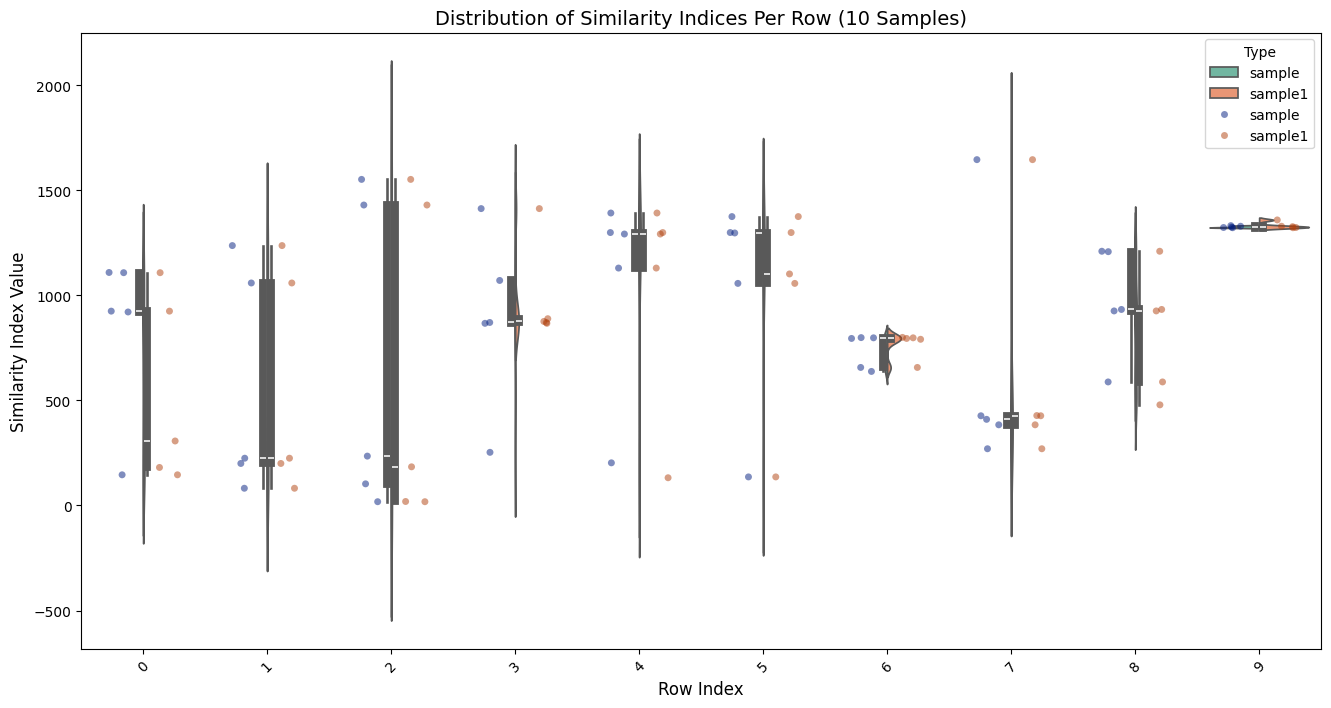

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists into a long-form DataFrame
df = df_results
expanded_data = []
for i, row in df.iterrows():
    for val1, val2 in zip(row["sample_most_similar_index"], row["sample1_most_similar_index"]):
        expanded_data.append({"Row": i, "Type": "sample", "Value": val1})
        expanded_data.append({"Row": i, "Type": "sample1", "Value": val2})

expanded_df = pd.DataFrame(expanded_data)

# Increase figure size
plt.figure(figsize=(16, 8))  

# Violin plot with better width & color contrast
sns.violinplot(x="Row", y="Value", hue="Type", data=expanded_df, 
               split=True, palette="Set2", bw_adjust=0.5)

# Overlay individual points for clarity
sns.stripplot(x="Row", y="Value", hue="Type", data=expanded_df, 
              dodge=True, jitter=0.2, alpha=0.5, palette="dark")

plt.title("Distribution of Similarity Indices Per Row (10 Samples)", fontsize=14)
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Similarity Index Value", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.legend(title="Type")
plt.show()


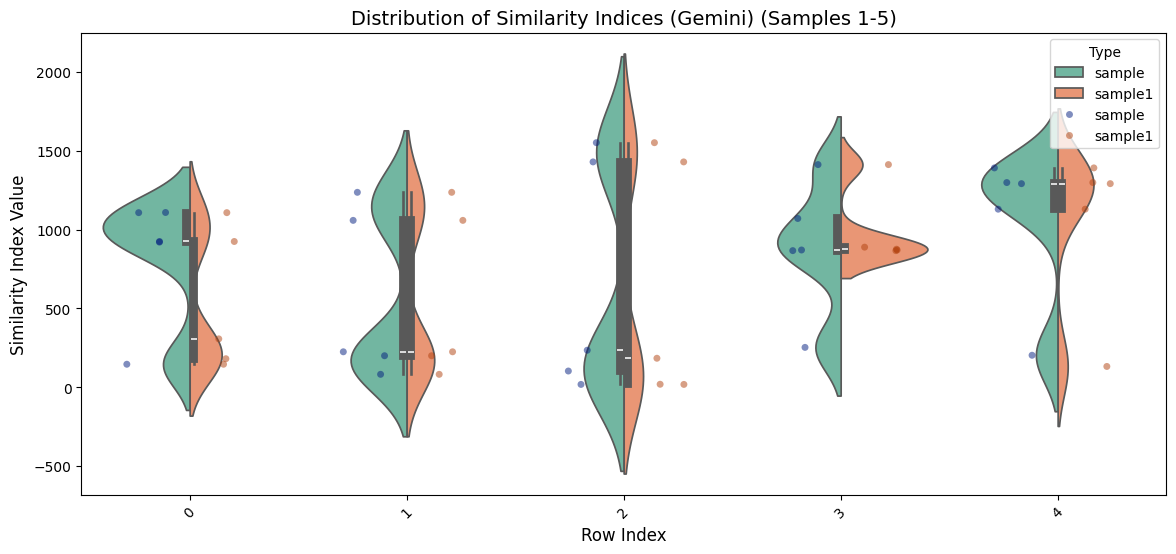

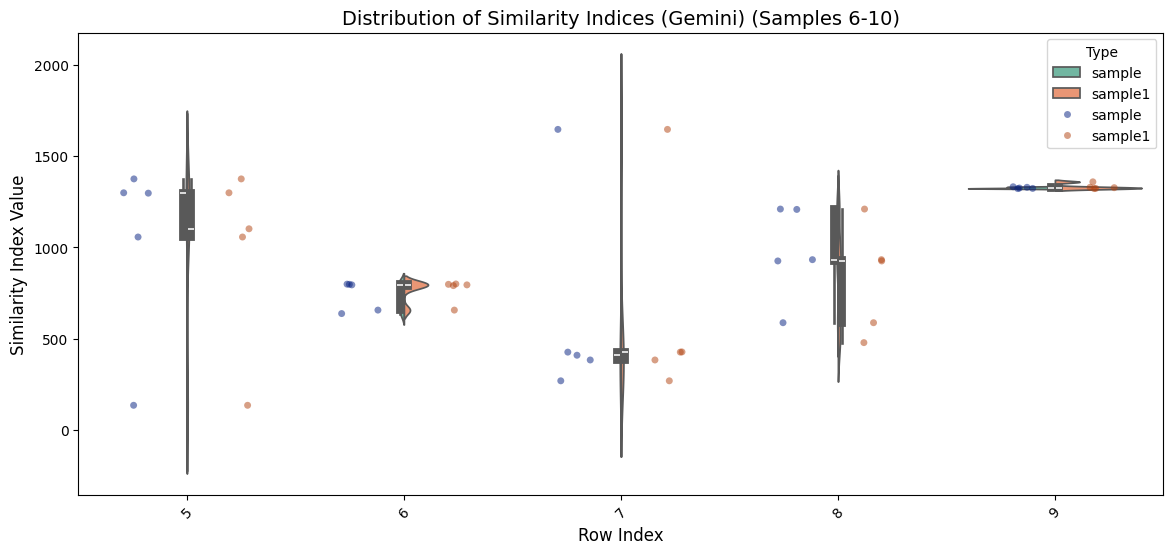

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists into a long-form DataFrame
df = df_results
expanded_data = []
for i, row in df.iterrows():
    for val1, val2 in zip(row["sample_most_similar_index"], row["sample1_most_similar_index"]):
        expanded_data.append({"Row": i, "Type": "sample", "Value": val1})
        expanded_data.append({"Row": i, "Type": "sample1", "Value": val2})

expanded_df = pd.DataFrame(expanded_data)

# Split data into two halves
df_part1 = expanded_df[expanded_df["Row"] < 5]  # First 5 rows
df_part2 = expanded_df[expanded_df["Row"] >= 5]  # Last 5 rows

# Create a function to plot violin plots
def plot_violin(data, title):
    plt.figure(figsize=(14, 6))  
    sns.violinplot(x="Row", y="Value", hue="Type", data=data, 
                   split=True, palette="Set2", bw_adjust=0.5)
    
    sns.stripplot(x="Row", y="Value", hue="Type", data=data, 
                  dodge=True, jitter=0.2, alpha=0.5, palette="dark")
    
    plt.title(title, fontsize=14)
    plt.xlabel("Row Index", fontsize=12)
    plt.ylabel("Similarity Index Value", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.legend(title="Type", loc="upper right")
    plt.show()

# Plot first and second parts separately
plot_violin(df_part1, "Distribution of Similarity Indices (Gemini) (Samples 1-5)")
plot_violin(df_part2, "Distribution of Similarity Indices (Gemini) (Samples 6-10)")


In [80]:
df_results.to_csv(r"..\Results\results_gemini_text-005.csv", index=False)

In [ ]:
# # Initialize model
# embeddings_model1 = VertexAIEmbeddings(model_name="text-embedding-005")

# # Load document
# doc = pd.read_parquet(r"..\New_Embeddings_2025\embeddings_gemini_text-005.parquet", engine="pyarrow")

# # Define sample lists
# sample1= get_random_sentence(doc['Processed_Content'][random.randint(1,doc.shape[0])])
# sample2= get_random_sentence(doc['Processed_Content'][random.randint(1,doc.shape[0])])
# sample3= get_random_sentence(doc['Processed_Content'][random.randint(1,doc.shape[0])])
# sample4 = get_random_sentence(doc['Processed_Content'][random.randint(1,doc.shape[0])])
# sample5 = get_random_sentence(doc['Processed_Content'][random.randint(1,doc.shape[0])])

# sample_list = [sample1, sample2, sample3, sample4, sample5]
# sample1_list = [paraphrase_text(sample1), paraphrase_text(sample2), paraphrase_text(sample3), paraphrase_text(sample4), paraphrase_text(sample5)]

# # Get most similar indices
# df_results = find_most_similar(sample_list, sample1_list, embeddings_model1, doc)
# print(df_results)

In [86]:
tokenizer = AutoTokenizer.from_pretrained('voyageai/voyage-2')
doc1 = pd.read_parquet("../New_Embeddings_2025/embeddings_voyage.parquet", engine="pyarrow")

def chunk_text(text, max_tokens=4096, overlap=512):
    """
    Splits text into chunks based on the token limit of voyage-law-2 tokenizer.
    Uses a sliding window approach with overlap.
    
    Args:
        text (str): The input text to be chunked.
        max_tokens (int): Maximum tokens per chunk (4096 for voyage-law-2).
        overlap (int): Overlapping tokens to maintain context between chunks.

    Returns:
        list of str: List of text chunks.
    """
    tokens = tokenizer.encode(text, add_special_tokens=False)

    chunks = []
    start = 0
    while start < len(tokens):
        chunk = tokens[start:start + max_tokens]
        chunks.append(tokenizer.decode(chunk))
        start += max_tokens - overlap

    return chunks

def get_embeddings(texts, model="voyage-law-2", batch_size=32):
    """
    Compute embeddings using the VoyageAI Python client in batches.

    Args:
        texts (list of str): List of text data to embed.
        model (str): The embedding model to use.
        batch_size (int): Number of texts per batch.

    Returns:
        list: List of embedding vectors.
    """
    embeddings = []

    texts = [str(text) for text in texts]  

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size] 
        
        try:
            response = vo.embed(batch, model=model)
            batch_embeddings = response.embeddings  
            embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error processing batch {i // batch_size + 1}: {e}")

    return embeddings

def find_most_similar_voyage(sample_list, sample1_list, doc):
    results = {"sample": [], "sample1": [], "sample_most_similar_index": [], "sample1_most_similar_index": []}
    embeddings = np.vstack(doc['Embedding'].values)
    
    for sample, sample1 in zip(sample_list, sample1_list):
        # Process sample
        chunked_sample = chunk_text(sample)
        query_embedding_sample = get_embeddings(chunked_sample)
        query_embedding_sample = np.array(query_embedding_sample).reshape(1, -1)
        similarities_sample = cosine_similarity(query_embedding_sample, embeddings)
        most_similar_index_sample = np.argsort(similarities_sample[0])[-5:][::-1]
        
        # Process sample1
        chunked_sample1 = chunk_text(sample1)
        query_embedding_sample1 = get_embeddings(chunked_sample1)
        query_embedding_sample1 = np.array(query_embedding_sample1).reshape(1, -1)
        similarities_sample1 = cosine_similarity(query_embedding_sample1, embeddings)
        most_similar_index_sample1 = np.argsort(similarities_sample1[0])[-5:][::-1]
        
        # Store results
        results["sample"].append(sample)
        results["sample1"].append(sample1)
        results["sample_most_similar_index"].append(list(most_similar_index_sample))
        results["sample1_most_similar_index"].append(list(most_similar_index_sample1))
    
    return pd.DataFrame(results)





In [87]:
# Define sample lists
sample1= "Whoever harbors or conceals any person who he knows, or has reasonable grounds to believe or suspect, has committed, or is about to commit, an offense under this section, shall be fined under this title or imprisoned not more than ten years, or both."
sample2= "Any property, real or personal, used or intended to be used to commit or to facilitate the commission of any violation of this chapter."
sample3="participates in a strike, or asserts the right to strike, against the Government of the United States or the government of the District of Columbia; or"
sample4 = "Whoever, being an officer or other person charged by any Act of Congress with the safe-keeping of the public moneys, loans, uses, or converts to his own use, or deposits in any bank, including any branch"
sample5 = "evidence has been presented by the foreign government that indicates that had the offenses been committed in the United States, they would constitute crimes of violence as defined under section 16 of this title"
sample6="forcibly thrusts any part of himself or any object within or upon that portion of any building or premises located within the United States, which portion is used or occupied for official business or for diplomatic, consular, or residential purposes"
sample7="Training conducted during regular employment.—An officer or employee of the Bureau of Prisons who completes a training course required under paragraph (1) shall do so during the course of that officer or employees regular employment"
sample8="the court finds reasonable cause to believe that providing immediate notification of the execution of the warrant may have an adverse result (as defined in section 2705, except if the adverse results consist only of unduly delaying a trial);"
sample9= "The Secretaries of the Army, Navy, and Air Force and the Federal Security Administrator shall take such steps as they deem necessary to suppress and prevent such violations thereof, and shall accept the cooperation of the authorities of States and their counties, districts, and other political subdivisions in carrying out the purpose of this section."
sample10="Whoever, having taken charge of any mail, voluntarily quits or deserts the same before he has delivered it into the post office at the termination of the route, or to some known mail carrier, messenger, agent, or other employee in the Postal Service authorized to receive the same"

sample_list = [sample1, sample2, sample3, sample4, sample5, sample6, sample7, sample8, sample9, sample10]   
sample1_list = [paraphrase_text(sample1), paraphrase_text(sample2), paraphrase_text(sample3), paraphrase_text(sample4), paraphrase_text(sample5), paraphrase_text(sample6), paraphrase_text(sample7), paraphrase_text(sample8), paraphrase_text(sample9), paraphrase_text(sample10)]    

# Get most similar indices
df_results1 = find_most_similar_voyage(sample_list, sample1_list, doc1)
print(df_results1)

                                              sample  \
0  Whoever harbors or conceals any person who he ...   
1  Any property, real or personal, used or intend...   
2  participates in a strike, or asserts the right...   
3  Whoever, being an officer or other person char...   
4  evidence has been presented by the foreign gov...   
5  forcibly thrusts any part of himself or any ob...   
6  Training conducted during regular employment.—...   
7  the court finds reasonable cause to believe th...   
8  The Secretaries of the Army, Navy, and Air For...   
9  Whoever, having taken charge of any mail, volu...   

                                             sample1  \
0  Anyone who hides or protects someone they know...   
1  Any property, whether real estate or possessio...   
2  Engages in, or advocates for, a strike against...   
3  Any government official responsible for protec...   
4  A foreign government has provided evidence sho...   
5  Illegally enters or forces entry into any pa

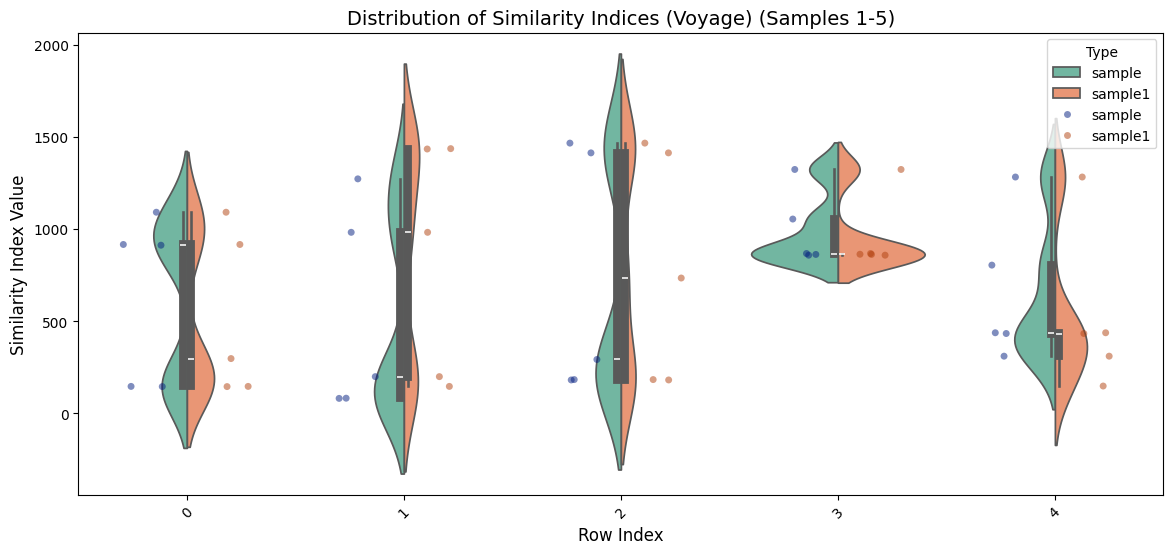

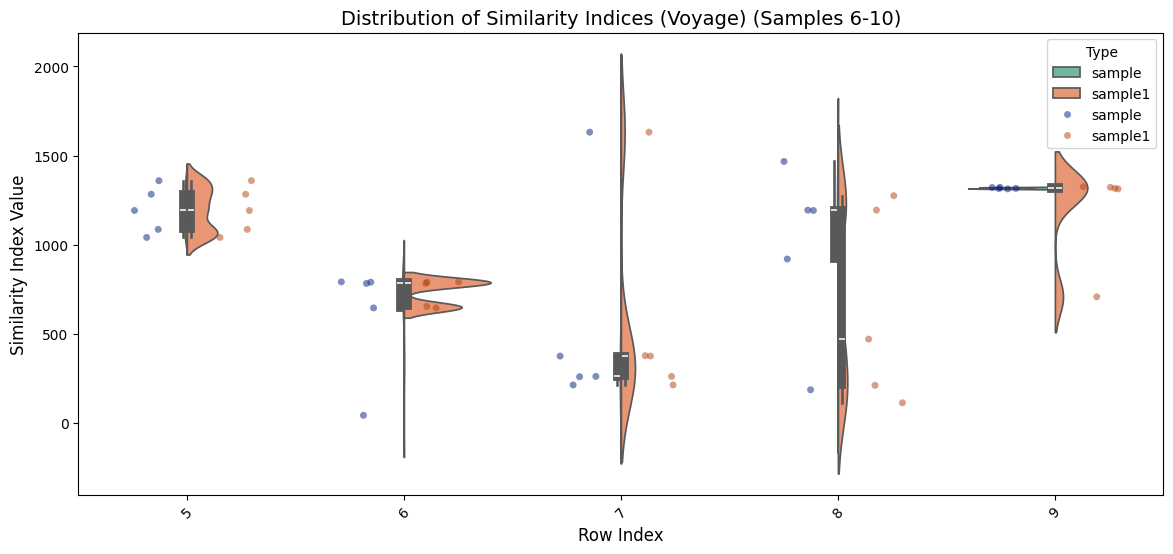

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists into a long-form DataFrame
df = df_results1
expanded_data = []
for i, row in df.iterrows():
    for val1, val2 in zip(row["sample_most_similar_index"], row["sample1_most_similar_index"]):
        expanded_data.append({"Row": i, "Type": "sample", "Value": val1})
        expanded_data.append({"Row": i, "Type": "sample1", "Value": val2})

expanded_df = pd.DataFrame(expanded_data)

# Split data into two halves
df_part1 = expanded_df[expanded_df["Row"] < 5]  # First 5 rows
df_part2 = expanded_df[expanded_df["Row"] >= 5]  # Last 5 rows

# Create a function to plot violin plots
def plot_violin(data, title):
    plt.figure(figsize=(14, 6))  
    sns.violinplot(x="Row", y="Value", hue="Type", data=data, 
                   split=True, palette="Set2", bw_adjust=0.5)
    
    sns.stripplot(x="Row", y="Value", hue="Type", data=data, 
                  dodge=True, jitter=0.2, alpha=0.5, palette="dark")
    
    plt.title(title, fontsize=14)
    plt.xlabel("Row Index", fontsize=12)
    plt.ylabel("Similarity Index Value", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.legend(title="Type", loc="upper right")
    plt.show()

# Plot first and second parts separately
plot_violin(df_part1, "Distribution of Similarity Indices (Voyage) (Samples 1-5)")
plot_violin(df_part2, "Distribution of Similarity Indices (Voyage) (Samples 6-10)")


In [89]:
df_results1.to_csv(r"..\Results\results_voyage.csv", index=False)